In [1]:
from datetime import datetime
import numpy as np
import os

export_date =  '240124'
joystick_length = 15 #cm
analog_threshold = 71

mice = ['6_2', '6_3']

input_folder = f'data{os.sep}raw{os.sep}Behavior'
reports_folder = f'data{os.sep}reports{os.sep}{export_date}'
print(export_date, mice, 'saving to', reports_folder)

240124 ['6_2', '6_3'] saving to data/reports/240124


In [2]:
from bs4 import BeautifulSoup
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import sys
from tqdm.auto import tqdm
sys.path.append('src')

from importrhdutilities import load_file as read_rhd

os.makedirs(reports_folder, exist_ok=True)

mice_recordings = []
mice_traces = {}
for mouse in mice:
    session_paths = glob.glob(f'{input_folder}{os.sep}{mouse}{os.sep}{mouse}_*_{export_date}_*')
    mice_traces[mouse] = { 'adc': [], 'dig': [], 't_adc': [], 't_dig': []  }

    for session_path in session_paths:
        session = session_path.split(os.sep)[-1]

        recording_paths = sorted(glob.glob(f'{session_path}{os.sep}*.rhd'))
        print(f'mouse {mouse} -> session {session} -> {len(recording_paths)} rhd files')

        session_length, sampling_frequency = 0, -1
        session_recording_paths = []
        for recording_path in (pbar := tqdm(recording_paths)):
            recording = recording_path.split(os.sep)[-1]
            pbar.set_description(f'{mouse} -> {session} -> {recording}')

            raw_data, data_present = read_rhd(recording_path)
            if not data_present:
                print(f'[no data] Skipping! {mouse} -> {session} -> {recording}')
                continue
            session_length += raw_data['amplifier_data'].shape[1]
            sampling_frequency = raw_data['frequency_parameters']['amplifier_sample_rate']
            session_recording_paths.append(recording_path)
            mice_traces[mouse]['adc'].append(raw_data['board_adc_data'])
            mice_traces[mouse]['dig'].append(raw_data['board_dig_in_data'])
            mice_traces[mouse]['t_adc'].append(raw_data['t_board_adc'])
            mice_traces[mouse]['t_dig'].append(raw_data['t_dig'])
        session_duration = session_length / sampling_frequency

        with open(f'{session_path}{os.sep}settings.xml', 'r') as f:
            intan_settings = f.read()
        intan_settings = BeautifulSoup(intan_settings, 'xml')
        session_trigger_enabled = all([channel['Enabled']=='True' for channel in intan_settings.find_all('SignalGroup', {'Prefix': 'DIGITAL-IN'})[0].find_all('Channel')])

        mice_recordings.append({
            'date': export_date,
            'mouse': mouse,
            'session': session,
            'days_trained': re.match(rf'{mouse}_(?P<days_trained>.*)_{export_date}', session).group('days_trained'),
            'timestamp': datetime.strptime(re.search(r'\d{6}_\d{6}$', session).group(), '%y%m%d_%H%M%S'),
            'intan_trigger_enabled': session_trigger_enabled,
            'intan_sampling_frequency': sampling_frequency,
            'intan_duration(s)': session_duration,
            'intan_recording_paths': session_recording_paths,
        })

        mice_traces[mouse]['adc'] = np.hstack(mice_traces[mouse]['adc'])
        mice_traces[mouse]['dig'] = np.hstack(mice_traces[mouse]['dig'])
        mice_traces[mouse]['t_adc'] = np.hstack(mice_traces[mouse]['t_adc'])
        mice_traces[mouse]['t_dig'] = np.hstack(mice_traces[mouse]['t_dig'])
mice_recordings = pd.json_normalize(mice_recordings).sort_values(by='timestamp')
mice_recordings

mouse 6_2 -> session 6_2_day24_240124_083523 -> 32 rhd files


  0%|          | 0/32 [00:00<?, ?it/s]

Reading data/raw/Behavior/6_2/6_2_day24_240124_083523/6_2_day24_240124_083523.rhd
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 2 board ADC channels.
Found 2 board digital input channels.
File contains 60.002 seconds of data.  Amplifiers were sampled at 30.00 kS/s.
No missing timestamps in data.

Reading data/raw/Behavior/6_2/6_2_day24_240124_083523/6_2_day24_240124_083623.rhd
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 2 board ADC channels.
Found 2 board digital input channels.
File contains 60.002 seconds of data.  Amplifiers were sampled at 30.00 kS/s.
No missing timestamps in data.

Reading data/raw/Behavior/6_2/6_2_day24_240124_083523/6_2_day24_240124_083723.rhd
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 2 board ADC channels.
Found 2 board digital input channels.
File contains 60.002 seconds of data.  Amplifiers were sampled at 30.00 kS/s.
No missing timestamps in data.

Reading data/raw/Behavior/6_2/6_2_day

,date,mouse,session,days_trained,timestamp,intan_trigger_enabled,intan_sampling_frequency,intan_duration(s),intan_recording_paths
0,240124,6_2,6_2_day24_240124_083523,day24,2024-01-24 08:35:23,True,30000.0,1890.773333,[data/raw/Behavior/6_2/6_2_day24_240124_083523...


In [3]:
arduino_events = []
arduino_event_paths = glob.glob(f'{input_folder}{os.sep}Event{os.sep}*')
for arduino_event_path in arduino_event_paths:
    with open(arduino_event_path, 'r') as f:
        line = f.readline() # skip the header
        while line.startswith('Date'):
            line = f.readline()
        timestamp = datetime.utcfromtimestamp(int(line.split(',')[0]))
        if timestamp.strftime('%y%m%d') == export_date:
            arduino_events.append({
                'timestamp': timestamp,
                'arduino_event_path': arduino_event_path,
            })
if len(arduino_events) > 0:
    arduino_events = pd.json_normalize(arduino_events).sort_values(by='timestamp')
else:
    arduino_events = pd.DataFrame({'timestamp': [], 'arduino_event_path': []})
    arduino_events['timestamp'] = pd.to_datetime(arduino_events['timestamp'])
arduino_events

,timestamp,arduino_event_path
1,2024-01-24 07:44:42,data/raw/Behavior/Event/01240744.TXT
0,2024-01-24 08:35:19,data/raw/Behavior/Event/01240835.TXT


In [4]:
# Merge export_date's joystick events
mice_recordings = pd.merge_asof(mice_recordings, arduino_events, on='timestamp', direction='nearest', tolerance=pd.Timedelta('300s'))
mice_recordings

,date,mouse,session,days_trained,timestamp,intan_trigger_enabled,intan_sampling_frequency,intan_duration(s),intan_recording_paths,arduino_event_path
0,240124,6_2,6_2_day24_240124_083523,day24,2024-01-24 08:35:23,True,30000.0,1890.773333,[data/raw/Behavior/6_2/6_2_day24_240124_083523...,data/raw/Behavior/Event/01240835.TXT


In [5]:
def extract_video_df(name, paths):
    videos = []
    for path in paths:
        matched = re.search(r'\d{4}-\d{2}-\d{2} \d{2}_\d{2}_\d{2}', path)
        if matched is not None:
            timestamp = datetime.strptime(matched.group(), '%Y-%m-%d %H_%M_%S')
            if timestamp.strftime('%y%m%d') == export_date:
                videos.append({
                    'timestamp': timestamp,
                    name: path,
                })
    if len(videos) == 0:
        videos = pd.DataFrame({'timestamp':[], name:[]})
        videos['timestamp'] = pd.to_datetime(videos['timestamp'])
    else:
        videos = pd.json_normalize(videos)
    return videos.sort_values(by='timestamp')

video_folder = f'{input_folder}{os.sep}Video'
video_timestamps = extract_video_df('video_timestamp_path', glob.glob(f'{video_folder}{os.sep}*timestamp.txt'))
videos = extract_video_df('video_path', glob.glob(f'{video_folder}{os.sep}*.h264'))
videos = pd.merge_asof(videos, video_timestamps, on='timestamp', direction='nearest', tolerance=pd.Timedelta('60s'))
videos

,timestamp,video_path,video_timestamp_path
0,2024-01-24 07:38:42,data/raw/Behavior/Video/2024-01-24 07_38_42.72...,data/raw/Behavior/Video/2024-01-24 07_38_42.72...
1,2024-01-24 08:35:40,data/raw/Behavior/Video/2024-01-24 08_35_40.24...,data/raw/Behavior/Video/2024-01-24 08_35_40.24...


In [6]:
# Merge export_date's video recordings
mice_recordings = pd.merge_asof(mice_recordings, videos, on='timestamp', direction='nearest', tolerance=pd.Timedelta('300s'))
mice_recordings

,date,mouse,session,days_trained,timestamp,intan_trigger_enabled,intan_sampling_frequency,intan_duration(s),intan_recording_paths,arduino_event_path,video_path,video_timestamp_path
0,240124,6_2,6_2_day24_240124_083523,day24,2024-01-24 08:35:23,True,30000.0,1890.773333,[data/raw/Behavior/6_2/6_2_day24_240124_083523...,data/raw/Behavior/Event/01240835.TXT,data/raw/Behavior/Video/2024-01-24 08_35_40.24...,data/raw/Behavior/Video/2024-01-24 08_35_40.24...


In [7]:
n_ms_per_s = 1000
n_s_per_min = 60
n_mm_per_cm = 10
ms_before, ms_after = 100, 300
analog_halfwidth = 2048
v_half = 3.3 / 2
bin_size = 20 #ms
bin_scale = n_ms_per_s / bin_size

intan_joystick_recording_start_duraiton_threshold = 3 # s
intan_video_recording_start_duraiton_threshold = 0.5 # s

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/analog_halfwidth))) # cm

def extract_trigger_start_and_end_indices(triggers):
    start_indices = np.where(~triggers[:-1] & triggers[1:])[0] + 1 # From False to True
    end_indices = np.where(triggers[:-1] & ~triggers[1:])[0] + 1 # From True to False

    if mice_traces[mouse]['dig'][0][0]:
        start_indices = np.insert(start_indices, 0, 0)

    if mice_traces[mouse]['dig'][0][-1]:
        end_indices = np.append(end_indices, len(triggers) - 1)
    return start_indices, end_indices

def compute_trigger_durations(times, start_indices, end_indices):
    return np.array([
        times[end_index] - times[start_index] for start_index, end_index in zip(start_indices, end_indices)
    ])

/tmp/ipykernel_7136/2345592067.py:136: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f'{reports_folder}{os.sep}{joystick_event_plot_file}',bbox_inches='tight')
/home/liulab/miniconda3/envs/xinyi-si-0.98.2/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


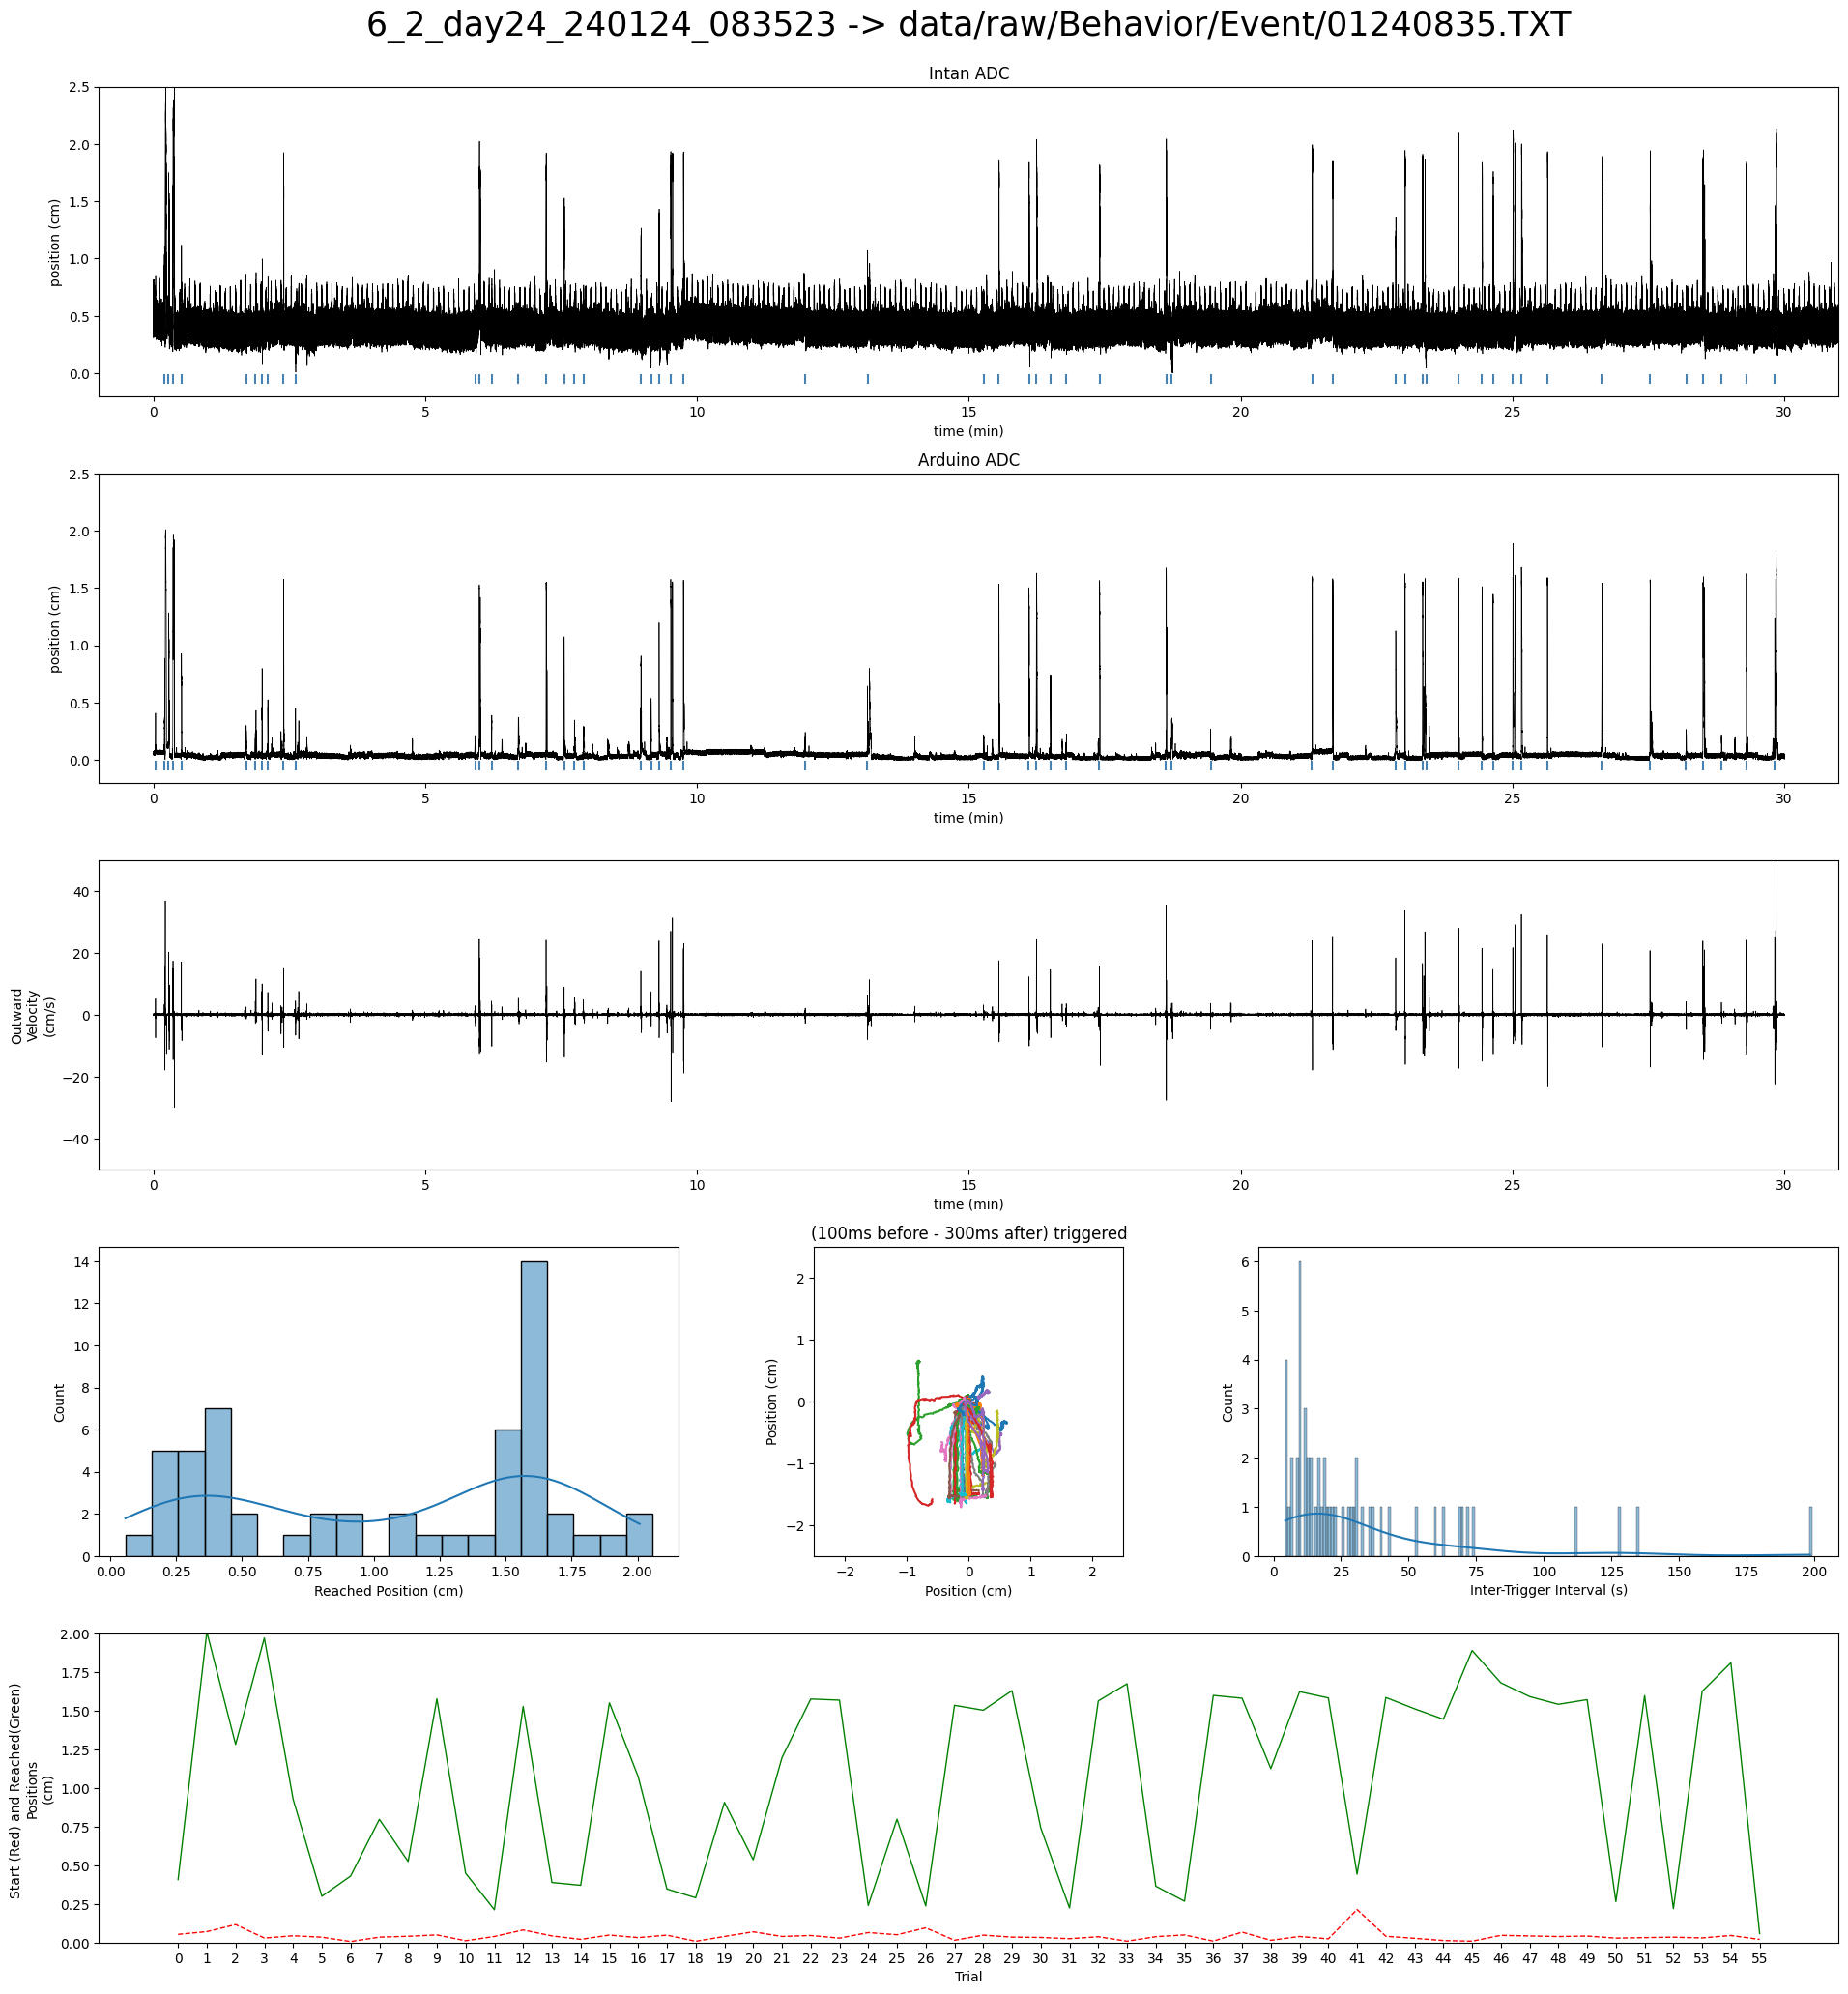

<Figure size 640x480 with 0 Axes>

In [14]:
for session_i, mouse in enumerate(mice_recordings['mouse']):
    mice_recording = mice_recordings.iloc[session_i:session_i+1]

    n_samples_per_ms = int(mice_recording['intan_sampling_frequency'].item() / n_ms_per_s)
    arduino_event_path = mice_recording['arduino_event_path'].item()

    if not os.path.isfile(str(arduino_event_path)):
        print(f'[No Event] {mice_recording["session"]} @ {arduino_event_path}')
        continue

    arduino_event = pd.read_csv(arduino_event_path, delimiter=',')
    arduino_event['time'] = (arduino_event['time'] - arduino_event['time'][0]) / n_ms_per_s

    fig = plt.figure(figsize=(20, 20), layout='constrained')
    fig.suptitle(f'{mice_recording["session"].item()} -> {arduino_event_path}', y=1, fontsize=25)

    # Plot Intan Recorded Joystick Position
    # ax = plt.subplot(5, 1, 1)
    ax = plt.axes([0.05, 0.8, 0.9, 0.16])

    intan_joystick_trigger_indices = extract_trigger_start_and_end_indices(mice_traces[mouse]['dig'][0])
    intan_joystick_trigger_durations = compute_trigger_durations(mice_traces[mouse]['t_dig'], *intan_joystick_trigger_indices)
    intan_joystick_recording_start_index_index = np.where(intan_joystick_trigger_durations > intan_joystick_recording_start_duraiton_threshold)[0].item()
    intan_joystick_recording_start_index = intan_joystick_trigger_indices[0][intan_joystick_recording_start_index_index]

    intan_t = (mice_traces[mouse]['t_adc'] - mice_traces[mouse]['t_adc'][intan_joystick_recording_start_index]) / n_s_per_min
    intan_position = np.sqrt(
        analog_to_digital((mice_traces[mouse]['adc'][0] - v_half) / v_half * analog_halfwidth) ** 2 + # x**2
        analog_to_digital((mice_traces[mouse]['adc'][1] - v_half) / v_half * analog_halfwidth) ** 2   # y**2
    )
    ax.plot(
        intan_t[intan_joystick_recording_start_index:],
        intan_position[intan_joystick_recording_start_index:],
        linewidth=0.5, color='black',
    )
    ax.scatter(
        intan_t[intan_joystick_trigger_indices[0][intan_joystick_recording_start_index_index+1:]],
        [-0.05] * len(intan_t[intan_joystick_trigger_indices[0][intan_joystick_recording_start_index_index+1:]]),
        color='steelblue', s=50, marker='|'
    )

    ax.set_title('Intan ADC')
    ax.set_ylabel('position (cm)')
    ax.set_xlabel('time (min)')
    ax.set_xlim(-1, 31)
    ax.set_ylim(-0.2, 2.5)


    # Plot Arduino Recorded Joystick Position
    ax = plt.axes([0.05, 0.6, 0.9, 0.16])
    arduino_joystick_start_indices = np.where((arduino_event['state'] == 0)[:-1].to_numpy() & (arduino_event['state'] == 1)[1:].to_numpy())[0] + 1 # From state 0 to state 1

    arduino_event['position'] = np.sqrt(
        analog_to_digital(arduino_event['x'] + arduino_event['joystickX_offset'] - analog_halfwidth) ** 2 +
        analog_to_digital(arduino_event['y'] + arduino_event['joystickY_offset'] - analog_halfwidth) ** 2)
    ax.plot(
        arduino_event['time'] / n_s_per_min,
        arduino_event['position'],
        linewidth=0.5, color='black'
    )
    ax.scatter(
        arduino_event['time'][arduino_joystick_start_indices]  / n_s_per_min,
        [-0.05] * len(arduino_joystick_start_indices),
        color='steelblue', s=50, marker='|'
    )
    ax.set_title('Arduino ADC')
    ax.set_ylabel('position (cm)')
    ax.set_xlabel('time (min)')
    ax.set_xlim(-1, 31)
    ax.set_ylim(-0.2, 2.5)

    # Plot the computed velocity by the binned time duration.
    ax = plt.axes([0.05, 0.4, 0.9, 0.16])

    arduino_event['binned_time'] = np.floor(arduino_event['time'] * bin_scale) / bin_scale
    binned_arduino_event = arduino_event[['binned_time', 'position']].groupby('binned_time').mean().reset_index().rename(columns={'position': 'binned_position'})
    # binned_joystick_event = arduino_event[['binned_time', 'position']].groupby('binned_time').apply(lambda x: x['position'].tolist()[0]).reset_index(name='binned_position')
    binned_arduino_event['dbinned_position'] = np.diff([binned_arduino_event['binned_position'][0]] + binned_arduino_event['binned_position'].tolist())
    binned_arduino_event['dbinned_time'] = np.diff([0] + binned_arduino_event['binned_time'].tolist())
    binned_arduino_event['outward_velocity'] = binned_arduino_event['dbinned_position'] / binned_arduino_event['dbinned_time']

    ax.plot(
        binned_arduino_event['binned_time'] / n_s_per_min, 
        binned_arduino_event['outward_velocity'], 
        color='black', linewidth=0.5
    )
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Outward\nVelocity\n(cm/s)')
    ax.set_xlim(-1, 31)
    ax.set_ylim(-50, 50)
    

    # Plot joystick movements.
    ax = plt.axes([0.05, 0.2, 0.3, 0.16])
    for trial in arduino_event['trial'].unique():
        trial_indices = np.where(arduino_event['trial'] == trial)[0]
        arduino_event.loc[trial_indices, 'trial_position'] = arduino_event.loc[trial_indices, 'position'].max()
    reached_positions = arduino_event['trial_position'].unique()
    sns.histplot(data=reached_positions, binwidth=0.1, kde=True, ax=ax)
    ax.set_xlabel('Reached Position (cm)')


    # Plot joystick movements.
    ax = plt.axes([0.42, 0.2, 0.16, 0.16])
    for arduino_joystick_start_index in arduino_joystick_start_indices:
        trigger_time = arduino_event['time'][arduino_joystick_start_index]
        trigger_start_time, trigger_end_time = trigger_time - ms_before / n_ms_per_s, trigger_time + ms_after / n_ms_per_s
        tigger_times = np.where((arduino_event['time'] >= trigger_start_time) & (arduino_event['time'] <= trigger_end_time))[0]
        ax.plot(analog_to_digital(arduino_event['x'][tigger_times]), analog_to_digital(arduino_event['y'][tigger_times]))
        ax.set_title(f'({ms_before}ms before - {ms_after}ms after) triggered')
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_xlabel('Position (cm)')
        ax.set_ylabel('Position (cm)')

    # Plot joystick movements.
    ax = plt.axes([0.65, 0.2, 0.3, 0.16])
    sns.histplot(data = np.diff(arduino_event['time'][arduino_joystick_start_indices]), binwidth=1, kde=True, ax=ax)
    ax.set_xlabel('Inter-Trigger Interval (s)')


    # Plot the start and final reached position for each trial.
    ax = plt.axes([0.05, 0, 0.9, 0.16])

    arduino_event['offset_position'] = np.sqrt(analog_to_digital(arduino_event['joystickX_offset']-analog_halfwidth)**2 + analog_to_digital(arduino_event['joystickY_offset']-analog_halfwidth)**2)

    ax.plot(arduino_event['trial'], arduino_event['offset_position'], color='red', linewidth=1, linestyle='dashed')
    ax.plot(arduino_event['trial'], arduino_event['trial_position'], color='green', linewidth=1)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Start (Red) and Reached(Green) \nPositions\n(cm)')
    ax.set_ylim(0, 2)
    ax.set_xticks(np.arange(arduino_event['trial'].max()+1))

    # Save plots.
    joystick_event_plot_file = arduino_event_path.replace(os.sep, '_').replace('.TXT', f'-{mice_recordings.iloc[session_i]["mouse"]}.png')
    plt.savefig(f'{reports_folder}{os.sep}{joystick_event_plot_file}',bbox_inches='tight')
    plt.show()
    plt.close('all')
    plt.clf()

    mice_recordings.loc[session_i, 'joystick_event_plot'] = joystick_event_plot_file
    mice_recordings.loc[session_i, 'target_move_distance(mm)'] = analog_to_digital(analog_threshold) * n_mm_per_cm
    mice_recordings.loc[session_i, 'joystick_length(cm)'] = joystick_length
    mice_recordings.loc[session_i, 'successful_trials'] = arduino_event['trial'].max()
    mice_recordings.loc[session_i, 'arduino_joystick_duration(s)'] = arduino_event['time'].max() - arduino_event['time'].min()
    mice_recordings.loc[session_i, 'intan_joystick_duration(s)'] = mice_traces[mouse]['t_adc'][intan_joystick_trigger_indices[1][-1]] - mice_traces[mouse]['t_adc'][intan_joystick_recording_start_index]
    mice_recordings.loc[session_i, 'mean_reached_distance(mm)'] = reached_positions.mean() * n_mm_per_cm